# CatBoost Regressor (Category Boosting)
The goal of this script is to document the generic steps in hyper parameter tuning and training a CatBoost Regression model.
This can be used to quickly produce a baseline model to compare to, but in practice, more modifications will be necessary for fine tuning and creating the best possible model.
#### Useful Resources:
 - Source Documentation: https://catboost.ai/en/docs/
 - Informative Article on CatBoost: https://towardsdatascience.com/why-you-should-learn-catboost-now-390fb3895f76
 - Deep dive into important metrics and methods: https://coderzcolumn.com/tutorials/machine-learning/catboost-an-in-depth-guide-python#3

In [1]:
##### Imports #####
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import catboost as cb
import pickle
import time
import shap
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [2]:
# reduce_memory_usage optimizes the amount of memory required for each column. Pandas defaults to 64 bit data types, but this is wasteful.
# This function looks at the range of values and assigns the most optimal type that keeps the data in tact

# Source for this code: https://www.mikulskibartosz.name/how-to-reduce-memory-usage-in-pandas/
def reduce_memory_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype
    if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
                    df[col] = df[col].astype(np.uint8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
                    df[col] = df[col].astype(np.uint16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
                    df[col] = df[col].astype(np.uint32)                    
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
                elif c_min > np.iinfo(np.uint64).min and c_max < np.iinfo(np.uint64).max:
                    df[col] = df[col].astype(np.uint64)
            elif str(col_type)[:5] == 'float':
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
# Read in data and run reduce memory function
# SIMPLE TEST EXAMPLE USING CALIFORNIA HOUSING DATASET
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
data = pd.DataFrame(housing.data)
data.columns = housing.feature_names
data['MedHouseVal'] = housing.target
reduced_df = reduce_memory_usage(data)
X, y = reduced_df.loc[:,reduced_df.columns != 'MedHouseVal'], reduced_df['MedHouseVal']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

Memory usage of dataframe is 1.42 MB
Memory usage after optimization is: 1.30 MB
Decreased by 8.3%


In [4]:
def CatBoost_Regressor_Training (cbr_params, scoring_param, X_train, X_test, y_train, y_test):
    # Parameter documentation: https://xgboost.readthedocs.io/en/latest/parameter.html#general-parameters
    
    # CatBoost specific data
    train_dataset = cb.Pool(X_train, y_train) 
    test_dataset = cb.Pool(X_test, y_test)
    
    # Perform GridSearch
    start_time = time.time()
    cbr_tuned = cb.CatBoostRegressor(loss_function=scoring_param, verbose = 0)
    cbr_grid_result = cbr_tuned.grid_search(cbr_params, train_dataset, cv = 2)
    
    # Report Results
    print('\nGrid Search Completed in:', round(time.time() - start_time,0),'seconds')
    print('Grid Search Best Parameters:',cbr_grid_result['params'],'\n')
    
    # Create predictions on test dataset
    cbr_preds = cbr_tuned.predict(X_test)
    
    # Store error metrics
    cbr_error_metrics = {'mae':0,'rmse':0,'mse':0,'r2':0,'adjusted_r2':0}
    cbr_error_metrics['mse'] = mean_squared_error(y_test, cbr_preds)
    cbr_error_metrics['rmse'] = np.sqrt(cbr_error_metrics['mse'])
    cbr_error_metrics['mae'] = mean_absolute_error(y_test, cbr_preds)
    cbr_error_metrics['r2'] = r2_score(y_test,cbr_preds)
    n = y_test.shape[0] # Number of rows
    k = len(X_test.columns) # Number of independent variables
    cbr_error_metrics['adjusted_r2'] = 1 - ((1-cbr_error_metrics['r2'])*(n-1)/(n-k-1)) # Adjusted R^2 calculation

    # Print error metrics
    print("\n----------------- FINAL MODEL ERROR METRICS -----------------")
    print("MSE: %f" % (cbr_error_metrics['mse']))
    print("RMSE: %f" % (cbr_error_metrics['rmse']))
    print("MAE: %f" % (cbr_error_metrics['mae']))
    print("R Squared: %f" % (cbr_error_metrics['r2']))
    print("Adjusted R Squared: %f" % (cbr_error_metrics['adjusted_r2']))
    
    # Returns the model, the best parameter list, predicted values, and common error metrics
    return cbr_tuned, cbr_grid_result['params'], cbr_preds, cbr_error_metrics, cbr_tuned.feature_importances_

In [5]:
cbr_params = {'iterations': [100, 150, 200], # The number of trees in our ensemble.
        'learning_rate': [0.03, 0.1], # The learning rate of the algorithm 
        'depth': [2, 4, 6, 8], # The max depth of the tree
        'l2_leaf_reg': [0.2, 0.5, 1, 3], # The coefficient of L2 regularization of a loss function. The default value is 3.
        'min_data_in_leaf': [1, 5, 10], # The minimum number of training samples per leaf of a tree. The default is 1.
        'rsm': [0.3,0.5,0.7]}
scoring_param = 'RMSE' # Options: https://catboost.ai/en/docs/concepts/loss-functions-regression#objectives-and-metrics

# Call the function to run hyperparameter optimization and training of final model
cbr_model, cbr_best_params, cbr_preds, cbr_error_metrics, cbr_feature_importances = CatBoost_Regressor_Training(cbr_params, scoring_param, X_train, X_test, y_train, y_test)



bestTest = 0.8035359636
bestIteration = 99

0:	loss: 0.8035360	best: 0.8035360 (0)	total: 226ms	remaining: 3m 14s

bestTest = 0.6355962296
bestIteration = 99

1:	loss: 0.6355962	best: 0.6355962 (1)	total: 377ms	remaining: 2m 42s

bestTest = 0.8035773332
bestIteration = 99

2:	loss: 0.8035773	best: 0.6355962 (1)	total: 544ms	remaining: 2m 36s

bestTest = 0.6372476916
bestIteration = 99

3:	loss: 0.6372477	best: 0.6355962 (1)	total: 691ms	remaining: 2m 28s

bestTest = 0.8036462478
bestIteration = 99

4:	loss: 0.8036462	best: 0.6355962 (1)	total: 855ms	remaining: 2m 26s

bestTest = 0.636397224
bestIteration = 99

5:	loss: 0.6363972	best: 0.6355962 (1)	total: 1.02s	remaining: 2m 26s

bestTest = 0.8028669152
bestIteration = 99

6:	loss: 0.8028669	best: 0.6355962 (1)	total: 1.18s	remaining: 2m 24s

bestTest = 0.6346163605
bestIteration = 99

7:	loss: 0.6346164	best: 0.6346164 (7)	total: 1.32s	remaining: 2m 21s

bestTest = 0.7401962433
bestIteration = 149

8:	loss: 0.7401962	best: 0.6346164 


bestTest = 0.5122287736
bestIteration = 199

71:	loss: 0.5122288	best: 0.5118942 (69)	total: 25.3s	remaining: 4m 38s

bestTest = 0.6400009774
bestIteration = 99

72:	loss: 0.6400010	best: 0.5118942 (69)	total: 25.7s	remaining: 4m 38s

bestTest = 0.5302492935
bestIteration = 99

73:	loss: 0.5302493	best: 0.5118942 (69)	total: 26.2s	remaining: 4m 39s

bestTest = 0.6416178765
bestIteration = 99

74:	loss: 0.6416179	best: 0.5118942 (69)	total: 26.6s	remaining: 4m 40s

bestTest = 0.5347160541
bestIteration = 99

75:	loss: 0.5347161	best: 0.5118942 (69)	total: 27.1s	remaining: 4m 40s

bestTest = 0.6435646003
bestIteration = 99

76:	loss: 0.6435646	best: 0.5118942 (69)	total: 27.5s	remaining: 4m 41s

bestTest = 0.5308202761
bestIteration = 99

77:	loss: 0.5308203	best: 0.5118942 (69)	total: 28s	remaining: 4m 42s

bestTest = 0.646966419
bestIteration = 99

78:	loss: 0.6469664	best: 0.5118942 (69)	total: 28.7s	remaining: 4m 44s

bestTest = 0.5328663512
bestIteration = 99

79:	loss: 0.5328664	b


bestTest = 0.5193802911
bestIteration = 199

141:	loss: 0.5193803	best: 0.4977897 (91)	total: 1m 1s	remaining: 5m 13s

bestTest = 0.5949740923
bestIteration = 199

142:	loss: 0.5949741	best: 0.4977897 (91)	total: 1m 2s	remaining: 5m 13s

bestTest = 0.5189834206
bestIteration = 199

143:	loss: 0.5189834	best: 0.4977897 (91)	total: 1m 2s	remaining: 5m 13s

bestTest = 0.6375903253
bestIteration = 99

144:	loss: 0.6375903	best: 0.4977897 (91)	total: 1m 3s	remaining: 5m 13s

bestTest = 0.5318198114
bestIteration = 99

145:	loss: 0.5318198	best: 0.4977897 (91)	total: 1m 3s	remaining: 5m 13s

bestTest = 0.6388374924
bestIteration = 99

146:	loss: 0.6388375	best: 0.4977897 (91)	total: 1m 4s	remaining: 5m 12s

bestTest = 0.5343445624
bestIteration = 99

147:	loss: 0.5343446	best: 0.4977897 (91)	total: 1m 4s	remaining: 5m 12s

bestTest = 0.6395514135
bestIteration = 99

148:	loss: 0.6395514	best: 0.4977897 (91)	total: 1m 5s	remaining: 5m 12s

bestTest = 0.5330198947
bestIteration = 99

149:	los


bestTest = 0.6661953531
bestIteration = 199

210:	loss: 0.6661954	best: 0.4864300 (187)	total: 1m 46s	remaining: 5m 29s

bestTest = 0.5690778993
bestIteration = 199

211:	loss: 0.5690779	best: 0.4864300 (187)	total: 1m 46s	remaining: 5m 28s

bestTest = 0.666117142
bestIteration = 199

212:	loss: 0.6661171	best: 0.4864300 (187)	total: 1m 47s	remaining: 5m 27s

bestTest = 0.5672859269
bestIteration = 199

213:	loss: 0.5672859	best: 0.4864300 (187)	total: 1m 47s	remaining: 5m 26s

bestTest = 0.6671700225
bestIteration = 199

214:	loss: 0.6671700	best: 0.4864300 (187)	total: 1m 47s	remaining: 5m 25s

bestTest = 0.565601612
bestIteration = 199

215:	loss: 0.5656016	best: 0.4864300 (187)	total: 1m 48s	remaining: 5m 24s

bestTest = 0.671166596
bestIteration = 99

216:	loss: 0.6711666	best: 0.4864300 (187)	total: 1m 48s	remaining: 5m 23s

bestTest = 0.5557804078
bestIteration = 99

217:	loss: 0.5557804	best: 0.4864300 (187)	total: 1m 48s	remaining: 5m 21s

bestTest = 0.671719694
bestIteration


bestTest = 0.4963665774
bestIteration = 149

279:	loss: 0.4963666	best: 0.4864300 (187)	total: 2m 27s	remaining: 5m 7s

bestTest = 0.5387740982
bestIteration = 199

280:	loss: 0.5387741	best: 0.4864300 (187)	total: 2m 28s	remaining: 5m 8s

bestTest = 0.4846559475
bestIteration = 199

281:	loss: 0.4846559	best: 0.4846559 (281)	total: 2m 29s	remaining: 5m 9s

bestTest = 0.5376461942
bestIteration = 199

282:	loss: 0.5376462	best: 0.4846559 (281)	total: 2m 31s	remaining: 5m 10s

bestTest = 0.482738963
bestIteration = 199

283:	loss: 0.4827390	best: 0.4827390 (283)	total: 2m 32s	remaining: 5m 11s

bestTest = 0.5367449599
bestIteration = 199

284:	loss: 0.5367450	best: 0.4827390 (283)	total: 2m 34s	remaining: 5m 13s

bestTest = 0.4851450329
bestIteration = 199

285:	loss: 0.4851450	best: 0.4827390 (283)	total: 2m 35s	remaining: 5m 14s

bestTest = 0.5394517906
bestIteration = 199

286:	loss: 0.5394518	best: 0.4827390 (283)	total: 2m 36s	remaining: 5m 15s

bestTest = 0.4851689243
bestIterati


bestTest = 0.6114108884
bestIteration = 149

348:	loss: 0.6114109	best: 0.4827390 (283)	total: 2m 57s	remaining: 4m 21s

bestTest = 0.529267848
bestIteration = 149

349:	loss: 0.5292678	best: 0.4827390 (283)	total: 2m 57s	remaining: 4m 21s

bestTest = 0.6134025567
bestIteration = 149

350:	loss: 0.6134026	best: 0.4827390 (283)	total: 2m 58s	remaining: 4m 20s

bestTest = 0.5282990176
bestIteration = 149

351:	loss: 0.5282990	best: 0.4827390 (283)	total: 2m 58s	remaining: 4m 20s

bestTest = 0.5856290191
bestIteration = 199

352:	loss: 0.5856290	best: 0.4827390 (283)	total: 2m 59s	remaining: 4m 19s

bestTest = 0.5123412489
bestIteration = 199

353:	loss: 0.5123412	best: 0.4827390 (283)	total: 2m 59s	remaining: 4m 19s

bestTest = 0.58348661
bestIteration = 199

354:	loss: 0.5834866	best: 0.4827390 (283)	total: 3m	remaining: 4m 18s

bestTest = 0.5125375981
bestIteration = 199

355:	loss: 0.5125376	best: 0.4827390 (283)	total: 3m 1s	remaining: 4m 18s

bestTest = 0.5836347155
bestIteration =


bestTest = 0.5353649034
bestIteration = 149

417:	loss: 0.5353649	best: 0.4827390 (283)	total: 3m 30s	remaining: 3m 44s

bestTest = 0.6230330879
bestIteration = 149

418:	loss: 0.6230331	best: 0.4827390 (283)	total: 3m 31s	remaining: 3m 44s

bestTest = 0.535807
bestIteration = 149

419:	loss: 0.5358070	best: 0.4827390 (283)	total: 3m 31s	remaining: 3m 43s

bestTest = 0.6219994057
bestIteration = 149

420:	loss: 0.6219994	best: 0.4827390 (283)	total: 3m 31s	remaining: 3m 42s

bestTest = 0.5328267905
bestIteration = 148

421:	loss: 0.5328268	best: 0.4827390 (283)	total: 3m 32s	remaining: 3m 42s

bestTest = 0.6230551502
bestIteration = 149

422:	loss: 0.6230552	best: 0.4827390 (283)	total: 3m 32s	remaining: 3m 41s

bestTest = 0.5346894741
bestIteration = 149

423:	loss: 0.5346895	best: 0.4827390 (283)	total: 3m 33s	remaining: 3m 41s

bestTest = 0.5952094982
bestIteration = 199

424:	loss: 0.5952095	best: 0.4827390 (283)	total: 3m 33s	remaining: 3m 40s

bestTest = 0.5210270735
bestIterati


bestTest = 0.6141377633
bestIteration = 99

487:	loss: 0.6141378	best: 0.4827390 (283)	total: 4m 18s	remaining: 3m 19s

bestTest = 0.7010317095
bestIteration = 149

488:	loss: 0.7010317	best: 0.4827390 (283)	total: 4m 18s	remaining: 3m 18s

bestTest = 0.5866981906
bestIteration = 149

489:	loss: 0.5866982	best: 0.4827390 (283)	total: 4m 18s	remaining: 3m 17s

bestTest = 0.6989655687
bestIteration = 149

490:	loss: 0.6989656	best: 0.4827390 (283)	total: 4m 19s	remaining: 3m 16s

bestTest = 0.5876931223
bestIteration = 149

491:	loss: 0.5876931	best: 0.4827390 (283)	total: 4m 19s	remaining: 3m 16s

bestTest = 0.6987852902
bestIteration = 149

492:	loss: 0.6987853	best: 0.4827390 (283)	total: 4m 19s	remaining: 3m 15s

bestTest = 0.5849381275
bestIteration = 149

493:	loss: 0.5849381	best: 0.4827390 (283)	total: 4m 19s	remaining: 3m 14s

bestTest = 0.7004967808
bestIteration = 149

494:	loss: 0.7004968	best: 0.4827390 (283)	total: 4m 20s	remaining: 3m 13s

bestTest = 0.5851452072
bestIter


bestTest = 0.6058755818
bestIteration = 99

556:	loss: 0.6058756	best: 0.4827390 (283)	total: 4m 51s	remaining: 2m 40s

bestTest = 0.5141711957
bestIteration = 99

557:	loss: 0.5141712	best: 0.4827390 (283)	total: 4m 52s	remaining: 2m 40s

bestTest = 0.6098182354
bestIteration = 99

558:	loss: 0.6098182	best: 0.4827390 (283)	total: 4m 52s	remaining: 2m 39s

bestTest = 0.5155819903
bestIteration = 99

559:	loss: 0.5155820	best: 0.4827390 (283)	total: 4m 53s	remaining: 2m 39s

bestTest = 0.5596956425
bestIteration = 149

560:	loss: 0.5596956	best: 0.4827390 (283)	total: 4m 54s	remaining: 2m 39s

bestTest = 0.4928099892
bestIteration = 149

561:	loss: 0.4928100	best: 0.4827390 (283)	total: 4m 55s	remaining: 2m 38s

bestTest = 0.5576786914
bestIteration = 149

562:	loss: 0.5576787	best: 0.4827390 (283)	total: 4m 56s	remaining: 2m 38s

bestTest = 0.4944207556
bestIteration = 149

563:	loss: 0.4944208	best: 0.4827390 (283)	total: 4m 57s	remaining: 2m 38s

bestTest = 0.5575168414
bestIterati


bestTest = 0.5529570025
bestIteration = 99

625:	loss: 0.5529570	best: 0.4827390 (283)	total: 5m 28s	remaining: 2m 4s

bestTest = 0.6637252103
bestIteration = 99

626:	loss: 0.6637252	best: 0.4827390 (283)	total: 5m 28s	remaining: 2m 4s

bestTest = 0.5497548639
bestIteration = 99

627:	loss: 0.5497549	best: 0.4827390 (283)	total: 5m 29s	remaining: 2m 3s

bestTest = 0.6648785755
bestIteration = 99

628:	loss: 0.6648786	best: 0.4827390 (283)	total: 5m 29s	remaining: 2m 3s

bestTest = 0.5502594874
bestIteration = 99

629:	loss: 0.5502595	best: 0.4827390 (283)	total: 5m 29s	remaining: 2m 2s

bestTest = 0.6667999831
bestIteration = 99

630:	loss: 0.6668000	best: 0.4827390 (283)	total: 5m 30s	remaining: 2m 1s

bestTest = 0.55127908
bestIteration = 99

631:	loss: 0.5512791	best: 0.4827390 (283)	total: 5m 30s	remaining: 2m 1s

bestTest = 0.6150631485
bestIteration = 149

632:	loss: 0.6150631	best: 0.4827390 (283)	total: 5m 31s	remaining: 2m

bestTest = 0.5270191855
bestIteration = 149

633:	l


bestTest = 0.6726318093
bestIteration = 199

694:	loss: 0.6726318	best: 0.4827390 (283)	total: 6m 3s	remaining: 1m 28s

bestTest = 0.5728621435
bestIteration = 199

695:	loss: 0.5728621	best: 0.4827390 (283)	total: 6m 4s	remaining: 1m 27s

bestTest = 0.6841875542
bestIteration = 99

696:	loss: 0.6841876	best: 0.4827390 (283)	total: 6m 4s	remaining: 1m 27s

bestTest = 0.5626625033
bestIteration = 99

697:	loss: 0.5626625	best: 0.4827390 (283)	total: 6m 4s	remaining: 1m 26s

bestTest = 0.6870520731
bestIteration = 99

698:	loss: 0.6870521	best: 0.4827390 (283)	total: 6m 5s	remaining: 1m 26s

bestTest = 0.5621557971
bestIteration = 99

699:	loss: 0.5621558	best: 0.4827390 (283)	total: 6m 5s	remaining: 1m 25s

bestTest = 0.685883049
bestIteration = 99

700:	loss: 0.6858830	best: 0.4827390 (283)	total: 6m 5s	remaining: 1m 25s

bestTest = 0.5623995433
bestIteration = 99

701:	loss: 0.5623995	best: 0.4827390 (283)	total: 6m 6s	remaining: 1m 24s

bestTest = 0.6854937127
bestIteration = 99

70


bestTest = 0.486429984
bestIteration = 199

763:	loss: 0.4864300	best: 0.4827390 (283)	total: 6m 49s	remaining: 53.6s

bestTest = 0.5417648653
bestIteration = 199

764:	loss: 0.5417649	best: 0.4827390 (283)	total: 6m 50s	remaining: 53.2s

bestTest = 0.4876517601
bestIteration = 197

765:	loss: 0.4876518	best: 0.4827390 (283)	total: 6m 52s	remaining: 52.7s

bestTest = 0.5440642615
bestIteration = 199

766:	loss: 0.5440643	best: 0.4827390 (283)	total: 6m 53s	remaining: 52.3s

bestTest = 0.487689736
bestIteration = 199

767:	loss: 0.4876897	best: 0.4827390 (283)	total: 6m 55s	remaining: 51.9s

bestTest = 0.7620982765
bestIteration = 99

768:	loss: 0.7620983	best: 0.4827390 (283)	total: 6m 55s	remaining: 51.3s

bestTest = 0.6204848594
bestIteration = 99

769:	loss: 0.6204849	best: 0.4827390 (283)	total: 6m 55s	remaining: 50.7s

bestTest = 0.7615455676
bestIteration = 99

770:	loss: 0.7615456	best: 0.4827390 (283)	total: 6m 55s	remaining: 50.1s

bestTest = 0.6177466465
bestIteration = 99




bestTest = 0.555432265
bestIteration = 199

832:	loss: 0.5554323	best: 0.4827390 (283)	total: 7m 21s	remaining: 16.4s

bestTest = 0.4901345629
bestIteration = 199

833:	loss: 0.4901346	best: 0.4827390 (283)	total: 7m 22s	remaining: 15.9s

bestTest = 0.5544913309
bestIteration = 199

834:	loss: 0.5544913	best: 0.4827390 (283)	total: 7m 23s	remaining: 15.4s

bestTest = 0.4933207109
bestIteration = 199

835:	loss: 0.4933207	best: 0.4827390 (283)	total: 7m 24s	remaining: 14.9s

bestTest = 0.5561541956
bestIteration = 199

836:	loss: 0.5561542	best: 0.4827390 (283)	total: 7m 25s	remaining: 14.4s

bestTest = 0.4894031354
bestIteration = 199

837:	loss: 0.4894031	best: 0.4827390 (283)	total: 7m 26s	remaining: 13.8s

bestTest = 0.5560512289
bestIteration = 199

838:	loss: 0.5560512	best: 0.4827390 (283)	total: 7m 27s	remaining: 13.3s

bestTest = 0.4926607185
bestIteration = 199

839:	loss: 0.4926607	best: 0.4827390 (283)	total: 7m 28s	remaining: 12.8s

bestTest = 0.6053960838
bestIteration = 

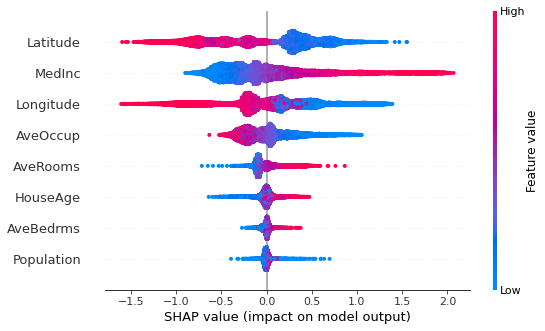

In [6]:
shap_values = cbr_model.get_feature_importance(cb.Pool(X, y), type='ShapValues')

expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

# Display Summary Plot of Feature Importances
shap.summary_plot(shap_values, X)
# shap.summary_plot(shap_values, X, max_display=3) # Only display top 3 most important variables

# For categorical variable importances, see this tutorial: https://github.com/catboost/tutorials/blob/master/model_analysis/shap_values_tutorial.ipynb

Text(0.5, 0, 'CatBoost Feature Importance')

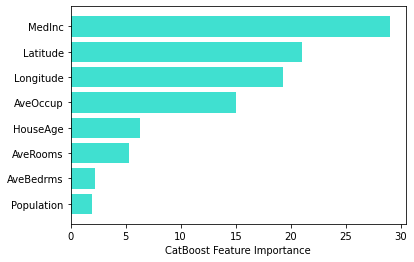

In [7]:
# Display plot of Feature Importances
sorted_feature_importance = cbr_model.feature_importances_.argsort()
ordered_features = [housing.feature_names[i] for i in sorted_feature_importance]
ordered_importances = [cbr_feature_importances[i] for i in sorted_feature_importance]
plt.barh(ordered_features, ordered_importances, color='turquoise')
plt.xlabel("CatBoost Feature Importance")

In [8]:
print("----------------- MODEL SUMMARY INFO -----------------")
print("Best Score           : ",cbr_model.best_score_)
print("Final Hyperparameters: ",cbr_best_params)
print("Data Feature Names   : ",cbr_model.feature_names_)
print("Feature Importance   : ",cbr_feature_importances)
print("Learning Rate        : ",cbr_model.learning_rate_)
print("Random Seed          : ",cbr_model.random_seed_)
print("Number of Trees      : ",cbr_model.tree_count_)
print("Number of Features   : ",cbr_model.n_features_in_)

----------------- MODEL SUMMARY INFO -----------------
Best Score           :  {'learn': {'RMSE': 0.37961672857306833}}
Final Hyperparameters:  {'min_data_in_leaf': 1, 'depth': 8, 'iterations': 200, 'rsm': 0.7, 'learning_rate': 0.1, 'l2_leaf_reg': 0.5}
Data Feature Names   :  ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Feature Importance   :  [28.97404968  6.28176085  5.30128248  2.17860214  1.93855285 14.98102707
 21.05988803 19.2848369 ]
Learning Rate        :  0.10000000149011612
Random Seed          :  0
Number of Trees      :  200
Number of Features   :  8


#### Useful Methods
**get_best_score()** - It returns best score of the estimator.

**get_params()** - It returns parameters which were given as dictionary when creating CatBoost estimator and their values as dictionary.

**get_all_params()** - It returns list of all parameters of CatBoost estimator and their values as dictionary.

**get_cat_feature_indices()** - It returns list of indices which has categorical features.

**get_feature_importance()** - It returns feature importance of individual feature according to trained model.

**shrink(ntree_end, ntree_start=0)** - It accepts two arguments which are end tree and starts tree to shrink ensemble to include only trees that come in that index range discarding all other trees.

**set_params()** - It can be used to set parameters of the estimator. Please make a note that this method will only work before the training model.

**calc_leaf_indexes(data, ntree_start=0,ntree_end=0)** - It takes as input data and returns index of leaf in each tree which was used to make prediction for sample. The output of this function will be n_samples x n_trees. It'll return all trees' leaf index for a sample.

**get_leaf_values()** - It returns actual leaf values of the trees in ensemble.

**get_leaf_weights()** - It returns leaf weights for each leaf of the trees in the ensemble.

In [9]:
# Display plot of independent NUMERIC variable statistics including actual vs predicted, histogram distribution, and partial dependence plot
cbr_model.calc_feature_statistics(X_train, y_train, feature=X_train.columns.tolist());

# # Display plot of independent CATEGORICAL variable statistics including histogram distribution, predicted vs actual, etc... 
# cbr_model.cat_feature_values(X_train, y_train, feature=categorical_cols_list);

In [10]:
# Display plot of independent numeric variables by varying the values and seeing predictions vary
cbr_model.plot_predictions(X_test[:5], features_to_change=X_train.columns.tolist());

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.945029 to fit


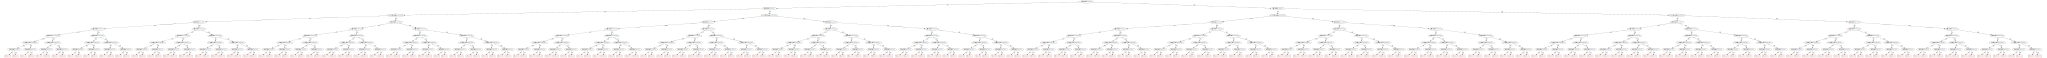

In [11]:
# Display plot of tree at given index
# pool = cb.Pool(X, y, cat_features=cat_features_index, feature_names=list(X.columns)) # If you have categorical features
pool = cb.Pool(X, y, feature_names=list(X.columns))
out = cbr_model.plot_tree(tree_idx=1,pool=pool)
out.render('tree', format="png")
out

In [12]:
# Save model as production ready python script
cbr_model.save_model('CatBoost_Regressor.py', format='python', pool=X_train)

In [13]:
# Save the model
pickle.dump(cbr_model, open("CatBoost_Regressor.pkl", "wb"))

In [14]:
# load the model
cbr_model_loaded = pickle.load(open("CatBoost_Regressor.pkl", "rb"))

In [15]:
# Sanity Checks to ensure model is the same as before
print("----------------- SANITY CHECKS -----------------")
print("Is the sum of difference between predictions zero?",(cbr_model.predict(X_test) - cbr_model_loaded.predict(X_test)).sum() == 0.0)
print("Do the feature importances dictionaries match?",cbr_feature_importances.sum() == cbr_model_loaded.feature_importances_.sum())

----------------- SANITY CHECKS -----------------
Is the sum of difference between predictions zero? True
Do the feature importances dictionaries match? True
